# Neural Network

In this notebook, we will implement a neural network model to classify success/failure of terrorist attacks in our database. Our goal is to find out how accurate this model is compared to LASSO regression and a neural network. For a discussion of what "success" means in this database, see our main notebook.

Our data are categorical one-hot-encoded feature vectors describing the attack, while the labels correspond to the success or failure of the attack. 

## Benefits

1. **Universal Approximation**: The generally high predictive power of Neural Networks can in part be explained by the Universal Approximation Theorem, which states that a multilayer perceptron is able to approximate continuous functions on compact subsets of $R^{n}$. 


2. **Binary Classification**: By employing a binary cross-entropy loss function, neural networks are well-suited to approach binary classification problems. In combination with the Universal Approximation Theorem, this means that a neural network can approximate any decision function in $R^{n}$, the space of independent variables. 

## Proprocessing

First, we load the data, generate one-hot-categorical variables, and 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
import keras

Using TensorFlow backend.


In [3]:
from preprocess_functions import load_data_relevant_cols, get_dummies
raw = load_data_relevant_cols()

/Users/Paul/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (4,6,8,10,11,12,17,18,24,29,31,33,35,37,38,39,41,43,45,46,47,49,51,53,54,55,57,58,59,60,61,62,63,64,73,76,79,82,84,86,88,90,92,94,96,97,106,108,114,115,121,123,125,126,127,128,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Paul/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (6,61,62,63,79,94,96,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [5]:
np.random.seed(159)

Lets look at some examples of the possible options for each category

In [6]:
print(raw.attacktype1_txt.unique()[0:10])

['Assassination' 'Hostage Taking (Kidnapping)' 'Bombing/Explosion'
 'Facility/Infrastructure Attack' 'Armed Assault' 'Hijacking' 'Unknown'
 'Unarmed Assault' 'Hostage Taking (Barricade Incident)']


In [7]:
print(raw.targtype1_txt.unique()[0:10])

['Private Citizens & Property' 'Government (Diplomatic)'
 'Journalists & Media' 'Police' 'Utilities' 'Military'
 'Government (General)' 'Airports & Aircraft' 'Business'
 'Educational Institution']


In [8]:
print(raw.targsubtype1_txt.unique()[0:10])

['Named Civilian' 'Diplomatic Personnel (outside of embassy, consulate)'
 'Radio Journalist/Staff/Facility' 'Embassy/Consulate'
 'Police Building (headquarters, station, school)'
 'Police Security Forces/Officers' 'Electricity'
 'Military Recruiting Station/Academy'
 'Government Building/Facility/Office'
 'Military Barracks/Base/Headquarters/Checkpost']


In [9]:
print(raw.weaptype1_txt.unique()[0:10])

['Unknown' 'Explosives/Bombs/Dynamite' 'Incendiary' 'Firearms' 'Chemical'
 'Fake Weapons' 'Melee' 'Sabotage Equipment'
 'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)'
 'Radiological']


In [10]:
print(raw.weapsubtype1_txt.unique()[0:10])

[nan 'Unknown Explosive Type' 'Unknown Gun Type' 'Automatic Weapon'
 'Molotov Cocktail/Petrol Bomb' 'Gasoline or Alcohol'
 'Rifle/Shotgun (non-automatic)' 'Arson/Fire'
 'Projectile (rockets, mortars, RPGs, etc.)' 'Vehicle']


To use the categorical variables for analysis, we need to convert them to one-hot-encoded dummy variables, using pandas built in get_dummies function

In [11]:
# Making one-hot-encoded dummy variables
rel_columns = ['attacktype1_txt', 'targtype1_txt', 'targsubtype1_txt', 'weaptype1_txt', 'weapsubtype1_txt']
X = get_dummies(raw, rel_columns)
Y = raw.success

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

## Hyperparameter Search:

Due to the large number of hyperparameters, grid search is impossible. Instead, we will run a hyperparameter search by first trying out different activation functions, then model architectures, then l1 and l2 regularization. 

Since the data is on the scale of hundreds of thousands of rows, it is highly likely that a neural network will do better than a linear model. 

We begin by trying different activation functions

In [31]:
model_tanh = Sequential()
model_tanh.add(Dense(units=10, activation='tanh', input_dim=182))
model_tanh.add(Dense(units=10, activation='tanh'))
model_tanh.add(Dense(units=1, activation='sigmoid'))

model_tanh.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_tanh = model_tanh.fit(X_train.values, y_train, epochs=25, batch_size=32,
                              validation_data=(X_test.values, y_test), verbose=0)

In [32]:
model_relu = Sequential()
model_relu.add(Dense(units=10, activation='relu', input_dim=182))
model_relu.add(Dense(units=10, activation='relu'))
model_relu.add(Dense(units=1, activation='sigmoid'))

model_relu.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_relu = model_relu.fit(X_train.values, y_train, epochs=25, batch_size=32,
                              validation_data=(X_test.values, y_test), verbose=0)

In [33]:
model_sigmoid = Sequential()
model_sigmoid.add(Dense(units=10, activation='sigmoid', input_dim=182))
model_sigmoid.add(Dense(units=10, activation='sigmoid'))
model_sigmoid.add(Dense(units=1, activation='sigmoid'))

model_sigmoid.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_sigmoid = model_sigmoid.fit(X_train.values, y_train, epochs=25, batch_size=32,
                                    validation_data=(X_test.values, y_test), verbose=0)

We will use the following functions to visualize the loss and binary accuracy for each model over successive epochs

In [18]:
def plot_loss(history, save=False, save_path=None):
    """
    Plots and optionally saves the loss of a keras history over 
    successive epochs of training. 
    """
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('binary cross-entropy loss')
    plt.title(str(history) + ' loss')
    if save:
        plt.savefig(save_path)
    plt.show()
    
def plot_accuracy(history, save=False, save_path=None):
    """
    Plots and optionally saves the binary accuracy of a keras history over
    successive epochs of training
    """
    plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')
    plt.plot(history.history['binary_accuracy'], label='accuracy')
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('binary accuracy')
    plt.title(str(history) + ' accuracy')
    if save:
        plt.savefig(save_path)
    plt.show()

### Visualizing results of Activation Function tuning

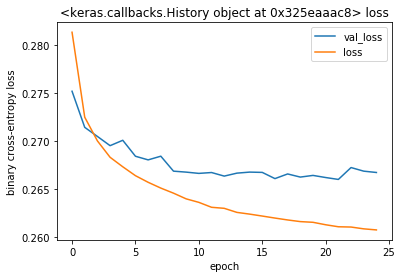

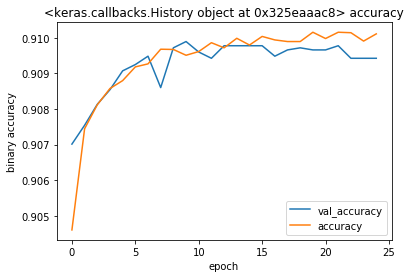

In [24]:
plot_loss(history_tanh)
plot_accuracy(history_tanh)

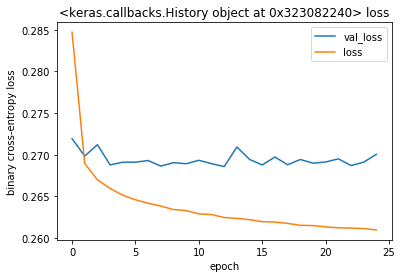

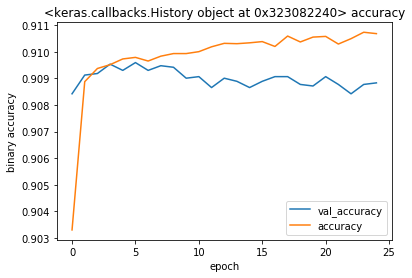

In [25]:
plot_loss(history_relu)
plot_accuracy(history_relu)

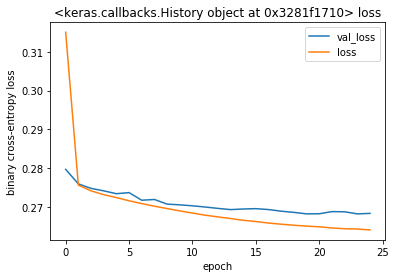

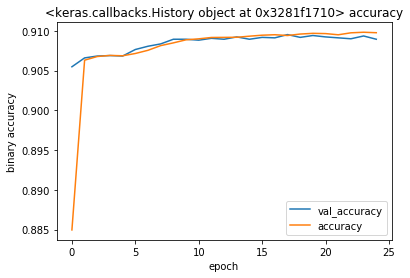

In [26]:
plot_loss(history_sigmoid)
plot_accuracy(history_sigmoid)

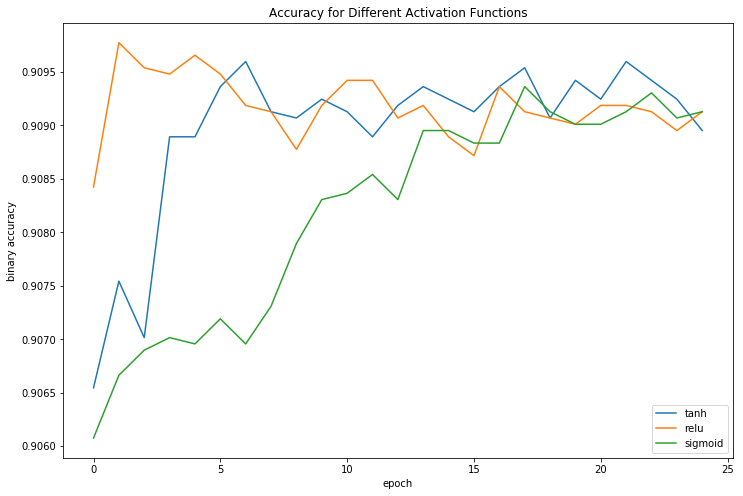

In [34]:
plt.figure(figsize=(12,8))
plt.plot(history_tanh.history['val_binary_accuracy'], label='tanh')
plt.plot(history_relu.history['val_binary_accuracy'], label='relu')
plt.plot(history_sigmoid.history['val_binary_accuracy'], label='sigmoid')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('binary accuracy')
plt.title('Accuracy for Different Activation Functions')
plt.savefig('figures/neural_net_activations')
plt.show()

In [38]:
np.where(history_relu.history['val_binary_accuracy'] == max(history_relu.history['val_binary_accuracy']))

(array([5]),)

In [39]:
np.where(history_tanh.history['val_binary_accuracy'] == max(history_tanh.history['val_binary_accuracy']))

(array([9]),)

In [40]:
max(history_relu.history['val_binary_accuracy'])

0.90959788672133979

In [41]:
max(history_tanh.history['val_binary_accuracy'])

0.9098914000761974

It appears that tanh with a few (<10) epochs are the best activation function. Now we will try a few different model architectures

In [13]:
# First, a wide model (more nodes per layer)
model_wide = Sequential()
model_wide.add(Dense(units=32, activation='tanh', input_dim=182))
model_wide.add(Dense(units=32, activation='tanh'))
model_wide.add(Dense(units=1, activation='sigmoid'))

model_wide.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_wide = model_wide.fit(X_train.values, y_train, epochs=10, batch_size=32,
                              validation_data=(X_test.values, y_test), verbose=0)


In [14]:
# Next, a wider model with even more nodes per layer
model_wider = Sequential()
model_wider.add(Dense(units=64, activation='tanh', input_dim=182))
model_wider.add(Dense(units=64, activation='tanh'))
model_wider.add(Dense(units=1, activation='sigmoid'))

model_wider.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_wider = model_wider.fit(X_train.values, y_train, epochs=10, batch_size=32,
                                validation_data=(X_test.values, y_test), verbose=0)


In [15]:
# Next, a deep model, with more layers
model_deep = Sequential()
model_deep.add(Dense(units=10, activation='tanh', input_dim=182))
model_deep.add(Dense(units=10, activation='tanh'))
model_deep.add(Dense(units=10, activation='tanh'))
model_deep.add(Dense(units=1, activation='sigmoid'))

model_deep.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_deep = model_deep.fit(X_train.values, y_train, epochs=15, batch_size=32,
                              validation_data=(X_test.values, y_test), verbose=0)


In [16]:
# Next, a bigger model, with both more layers and more nodes per layer
model_big = Sequential()
model_big.add(Dense(units=32, activation='tanh', input_dim=182))
model_big.add(Dense(units=32, activation='tanh'))
model_big.add(Dense(units=32, activation='tanh'))
model_big.add(Dense(units=1, activation='sigmoid'))

model_big.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_big = model_deep.fit(X_train.values, y_train, epochs=20, batch_size=32,
                             validation_data=(X_test.values, y_test), verbose=0)


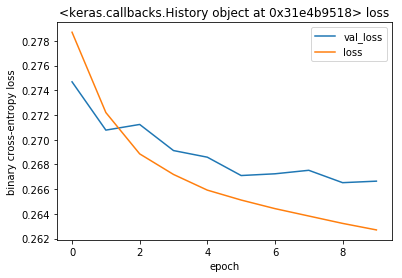

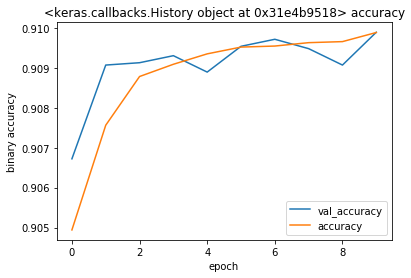

In [19]:
plot_loss(history_wide)
plot_accuracy(history_wide)

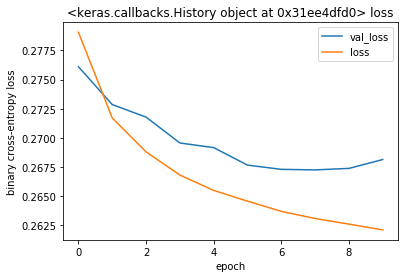

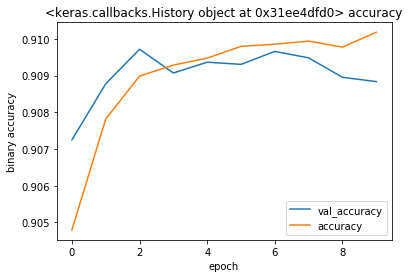

In [20]:
plot_loss(history_wider)
plot_accuracy(history_wider)

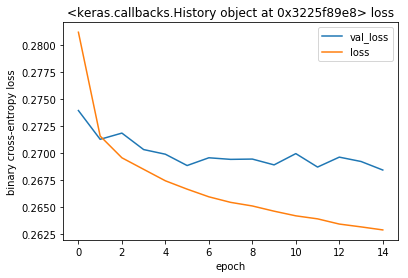

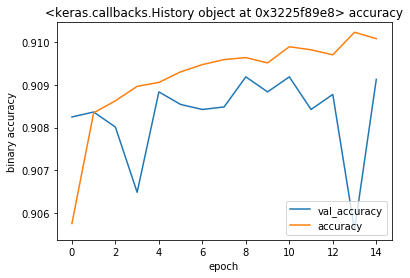

In [21]:
plot_loss(history_deep)
plot_accuracy(history_deep)

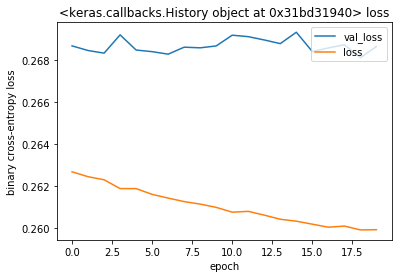

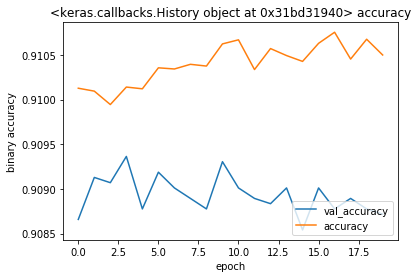

In [22]:
plot_loss(history_big)
plot_accuracy(history_big)

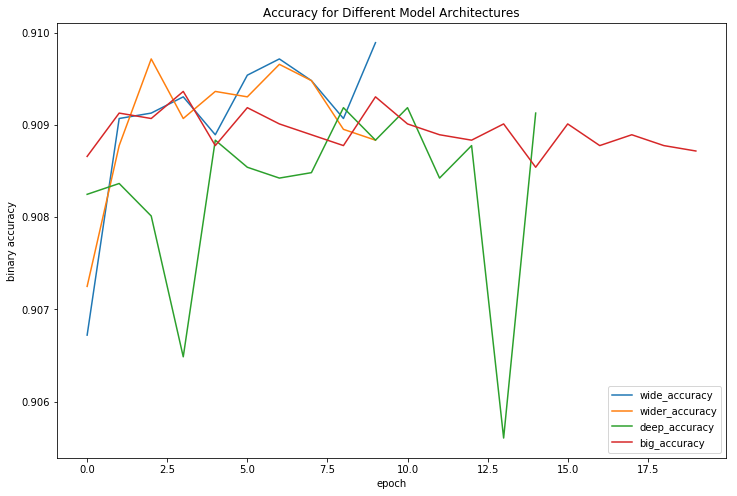

In [28]:
plt.figure(figsize=(12,8))
plt.plot(history_wide.history['val_binary_accuracy'], label='wide_accuracy')
plt.plot(history_wider.history['val_binary_accuracy'], label='wider_accuracy')
plt.plot(history_deep.history['val_binary_accuracy'], label='deep_accuracy')
plt.plot(history_big.history['val_binary_accuracy'], label='big_accuracy')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('binary accuracy')
plt.title('Accuracy for Different Model Architectures')
plt.savefig('figures/neural_net_architectures')
plt.show()

The differences in performance are negligible between different architectures. We will use the big model, (3 layers each with 64 layers) with 4 epochs, since the validation accuracy is most consistent. 

In [35]:
# Rerunning final model 
model_final = Sequential()
model_final.add(Dense(units=32, activation='tanh', input_dim=182))
model_final.add(Dense(units=32, activation='tanh'))
model_final.add(Dense(units=32, activation='tanh'))
model_final.add(Dense(units=1, activation='sigmoid'))

model_final.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_big = model_final.fit(X_train.values, y_train, epochs=3,
                              batch_size=32, validation_data=(X_test.values, y_test), verbose=0)


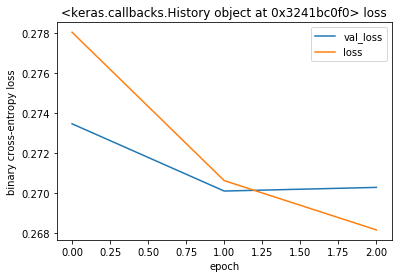

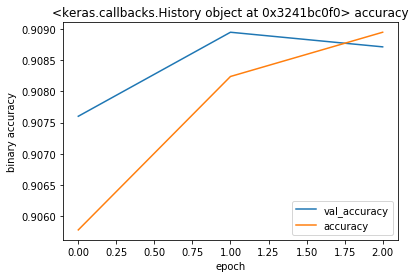

In [36]:
# Loss and accuracy for final model
plot_loss(history_big, save=True, save_path='figures/NN_loss')
plot_accuracy(history_big, save=True, save_path='figures/NN_accuracy')

## Discussion

### ROC Curves
Due to the skewed nature of the target class distribution, we will use ROC Curves to measure final performance. ROC Curves plot the true-positive-rate versus false-positive-rate over all possible rounding thresholds for the raw prediction. 

In [37]:
# ROC Curve analysis
y_pred = model_final.predict(X_test.values)
fpr, tpr, thresh = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

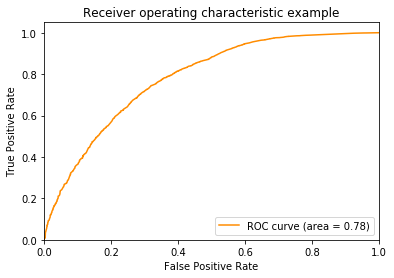

In [38]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('figures/NN_ROC')
plt.show()

In [39]:
# Choosing the rounding threshold where the true positive rate
# is greater than 0.9
loc = np.min(np.where(tpr > 0.9))
fpr[loc]
threshold = thresh[loc]
# Rounding the predictions based on the threshold
rounded = []
for i in y_pred:
    if i > threshold:
        rounded.append(1)
    else:
        rounded.append(0)
rounded_y_pred = np.array(rounded)

In [40]:
confusion_matrix(y_test, rounded_y_pred)

array([[  839,   921],
       [ 1542, 13733]])

- True Negatives: 861
- False Negatives: 1535
- True Positives: 13740
- False Positives: 899

In [41]:
# Calculating binary accuracy
accuracy = (13740 + 861) / (13740 + 861 + 1535 + 899)
accuracy

0.8571176988552979

### Conclusion
The neural network's predictive performance is better than the LASSO model, which is expected because as mentioned the universal approximation theorem implies that neural networks can fit a much more complex decision function. However, the overall accuracy of the neural network is worse than that of decision trees. 